In [1]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

from mlens.ensemble import SuperLearner

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import RidgeClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression, SGDClassifier

from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

import optuna
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning

ModuleNotFoundError: No module named 'dataframe_image'

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [ ]:
train_df = pd.read_csv('../../../data/feature/cba_train.csv')
test_df = pd.read_csv('../../../data/feature/cba_test.csv')

In [4]:
train_df.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Required_Car_Parking,Use_Promotion,Room_Rate,month_Expected_checkin,dayofweek_Expected_checkin,stay,booking_to_checkin,total_participants,Reservation_Status
0,0.002971,40,0.010376,-0.001419,0.007453,-0.444474,0.010791,0.003794,0.022095,0.005952,0.004285,218,7,2,1,41,4,1
1,0.002971,49,0.010376,0.006746,-0.012088,-0.444474,0.010791,0.003794,-0.069188,0.005952,-0.013100,185,7,2,1,36,6,1
2,0.002971,42,-0.017315,-0.001419,0.007453,-0.444474,0.010791,0.003794,0.022095,0.005952,-0.013100,119,7,3,4,3,6,1
3,-0.003235,25,0.014371,-0.003171,-0.012970,-0.444474,0.010791,0.003794,-0.069188,0.005952,0.004285,144,7,3,1,12,7,1
4,0.002971,62,0.010376,0.002616,0.012407,-0.444474,0.010791,0.003794,0.022095,-0.014993,0.004285,242,7,4,1,13,2,1


In [5]:
X, y = train_df.iloc[:, :-1], train_df.iloc[:,-1]
X_test = test_df.copy()
X, X_val, y, y_val = train_test_split(X, y, random_state=443, test_size=0.2, shuffle=False)

NameError: name 'train_test_split' is not defined

In [13]:
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=666)
        
    def objective(self, trial):
        model = create_model(trial)
        model.fit(X, y)
        preds = model.predict(X_val)
        if self.metric == 'acc':
            return accuracy_score(y_val, preds)
        else:
            return roc_auc_score(y_val, preds, average='macro')
            
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler)
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params

In [26]:
rf = RandomForestClassifier(
    random_state=666
)
rf.fit(X, y)
preds = rf.predict(X_val)

print('Random Forest accuracy: ', accuracy_score(y_val, preds))
print('Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
rf_f1_params = optimizer.optimize()
rf_f1_params['random_state'] = 666
rf_f1 = RandomForestClassifier(**rf_f1_params)
rf_f1.fit(X, y)
preds = rf_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
rf_acc_params = optimizer.optimize()
rf_acc_params['random_state'] = 666
rf_acc = RandomForestClassifier(**rf_acc_params)
rf_acc.fit(X, y)
preds = rf_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Random Forest: ', accuracy_score(y_val, preds))
print('Optimized Random Forest f1-score: ', f1_score(y_val, preds, average='macro'))

RandomForestClassifier(random_state=666)

Random Forest accuracy:  0.5678181818181818
Random Forest f1-score:  0.24190662558821188


RandomForestClassifier(max_depth=6, min_samples_leaf=7, n_estimators=132,
                       random_state=666)

Optimized on F1 score
Optimized Random Forest:  0.5694545454545454
Optimized Random Forest f1-score:  0.2418906394810009


RandomForestClassifier(max_depth=6, min_samples_leaf=7, n_estimators=132,
                       random_state=666)

Optimized on accuracy
Optimized Random Forest:  0.5694545454545454
Optimized Random Forest f1-score:  0.2418906394810009


In [15]:
xgb = XGBClassifier(
    random_state=666
)
xgb.fit(X, y)
preds = xgb.predict(X_val)

print('XGBoost accuracy: ', accuracy_score(y_val, preds))
print('XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    gamma = trial.suggest_uniform('gamma', 0.0000001, 1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    model = XGBClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        gamma=gamma, 
        subsample=subsample,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
xgb_f1_params = optimizer.optimize()
xgb_f1_params['random_state'] = 666
xgb_f1 = XGBClassifier(**xgb_f1_params)
xgb_f1.fit(X, y)
preds = xgb_f1.predict(X_val)

print('Optimized on F1 score')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
xgb_acc_params = optimizer.optimize()
xgb_acc_params['random_state'] = 666
xgb_acc = XGBClassifier(**xgb_acc_params)
xgb_acc.fit(X, y)
preds = xgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized XGBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized XGBoost f1-score: ', f1_score(y_val, preds, average='macro'))

f:\JetBrain Project Files\Pycharm\datastorm-2021\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[17:41:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=666, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

XGBoost accuracy:  0.5587272727272727
XGBoost f1-score:  0.25372078353601335
[17:41:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.9571209731002183,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.6389927461704404, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=666, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None,
              subsample=0.005901577759379538, tree_method='exact',
              validate_parameters=1, verbosity=None)

Optimized on F1 score
Optimized XGBoost accuracy:  0.5007272727272727
Optimized XGBoost f1-score:  0.3205277067086346
[17:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.6472458431462266,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.7825670249498173, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=666, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5936108906627577,
              tree_method='exact', validate_parameters=1, verbosity=None)

Optimized on accuracy
Optimized XGBoost accuracy:  0.5696363636363636
Optimized XGBoost f1-score:  0.24234656429216175


In [16]:
lgb = LGBMClassifier(
    random_state=666
)
lgb.fit(X, y)
preds = lgb.predict(X_val)

print('LightGBM accuracy: ', accuracy_score(y_val, preds))
print('LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    n_estimators = trial.suggest_int("n_estimators", 1, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
lgb_f1_params = optimizer.optimize()
lgb_f1_params['random_state'] = 666
lgb_f1 = LGBMClassifier(**lgb_f1_params)
lgb_f1.fit(X, y)
preds = lgb_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
lgb_acc_params = optimizer.optimize()
lgb_acc_params['random_state'] = 666
lgb_acc = LGBMClassifier(**lgb_acc_params)
lgb_acc.fit(X, y)
preds = lgb_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized LightGBM accuracy: ', accuracy_score(y_val, preds))
print('Optimized LightGBM f1-score: ', f1_score(y_val, preds, average='macro'))

LGBMClassifier(random_state=666)

LightGBM accuracy:  0.5669090909090909
LightGBM f1-score:  0.2433113472517496


LGBMClassifier(learning_rate=0.9655257204543717, max_depth=5,
               min_child_samples=11, n_estimators=135, num_leaves=1930,
               random_state=666)

Optimized on F1-score
Optimized LightGBM accuracy:  0.5274545454545455
Optimized LightGBM f1-score:  0.2937473211339136


LGBMClassifier(learning_rate=0.1128577423459426, max_depth=2,
               min_child_samples=167, n_estimators=149, num_leaves=1458,
               random_state=666)

Optimized on accuracy
Optimized LightGBM accuracy:  0.5694545454545454
Optimized LightGBM f1-score:  0.2418906394810009


In [18]:
dt = DecisionTreeClassifier(
    random_state=666
)
dt.fit(X, y)
preds = dt.predict(X_val)

print('Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 16)
    min_weight_fraction_leaf = trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    model = DecisionTreeClassifier(
        min_samples_split=min_samples_split, 
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
dt_f1_params = optimizer.optimize()
dt_f1_params['random_state'] = 666
dt_f1 = DecisionTreeClassifier(**dt_f1_params)
dt_f1.fit(X, y)
preds = dt_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
dt_acc_params = optimizer.optimize()
dt_acc_params['random_state'] = 666
dt_acc = DecisionTreeClassifier(**dt_acc_params)
dt_acc.fit(X, y)
preds = dt_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Decision Tree accuracy: ', accuracy_score(y_val, preds))
print('Optimized Decision Tree f1-score: ', f1_score(y_val, preds, average='macro'))

DecisionTreeClassifier(random_state=666)

Decision Tree accuracy:  0.4763636363636364
Decision Tree f1-score:  0.32387265321583175


DecisionTreeClassifier(max_depth=6, min_samples_leaf=7, min_samples_split=4,
                       min_weight_fraction_leaf=0.42209332142521727,
                       random_state=666)

Optimized on F1-score
Optimized Decision Tree accuracy:  0.5694545454545454
Optimized Decision Tree f1-score:  0.2418906394810009


DecisionTreeClassifier(max_depth=6, min_samples_leaf=7, min_samples_split=4,
                       min_weight_fraction_leaf=0.42209332142521727,
                       random_state=666)

Optimized on accuracy
Optimized Decision Tree accuracy:  0.5694545454545454
Optimized Decision Tree f1-score:  0.2418906394810009


In [19]:
bc = BaggingClassifier(
    random_state=666
)
bc.fit(X, y)
preds = bc.predict(X_val)

print('Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 1, 100)
    model = BaggingClassifier(
        n_estimators=n_estimators, 
        max_samples=max_samples, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
bc_f1_params = optimizer.optimize()
bc_f1_params['random_state'] = 666
bc_f1 = BaggingClassifier(**bc_f1_params)
bc_f1.fit(X, y)
preds = bc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
bc_acc_params = optimizer.optimize()
bc_acc_params['random_state'] = 666
bc_acc = BaggingClassifier(**bc_acc_params)
bc_acc.fit(X, y)
preds = bc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized Bagging Classifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized Bagging Classifier f1-score: ', f1_score(y_val, preds, average='macro'))

BaggingClassifier(random_state=666)

Bagging Classifier accuracy:  0.546
Bagging Classifier f1-score:  0.27114332077959236


BaggingClassifier(max_samples=81, n_estimators=3, random_state=666)

Optimized on F1-score
Optimized Bagging Classifier accuracy:  0.542
Optimized Bagging Classifier f1-score:  0.2911991497515896


BaggingClassifier(max_samples=46, n_estimators=132, random_state=666)

Optimized on accuracy
Optimized Bagging Classifier accuracy:  0.5694545454545454
Optimized Bagging Classifier f1-score:  0.2418906394810009


In [20]:
knn = KNeighborsClassifier()
knn.fit(X, y)
preds = knn.predict(X_val)

print('KNN accuracy: ', accuracy_score(y_val, preds))
print('KNN f1-score: ', f1_score(y_val, preds, average='macro'))

sampler = TPESampler(seed=0)
def create_model(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 25)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    return model

optimizer = Optimizer('f1')
knn_f1_params = optimizer.optimize()
knn_f1 = KNeighborsClassifier(**knn_f1_params)
knn_f1.fit(X, y)
preds = knn_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
knn_acc_params = optimizer.optimize()
knn_acc = KNeighborsClassifier(**knn_acc_params)
knn_acc.fit(X, y)
preds = knn_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized KNN accuracy: ', accuracy_score(y_val, preds))
print('Optimized KNN f1-score: ', f1_score(y_val, preds, average='macro'))

KNeighborsClassifier()

KNN accuracy:  0.5658181818181818
KNN f1-score:  0.257443845529631


KNeighborsClassifier(n_neighbors=3)

Optimized on F1-score
Optimized KNN accuracy:  0.5558181818181818
Optimized KNN f1-score:  0.2719929078023074


KNeighborsClassifier(n_neighbors=14)

Optimized on accuracy
Optimized KNN accuracy:  0.5698181818181818
Optimized KNN f1-score:  0.24323396639430314


In [22]:
abc = AdaBoostClassifier(
    random_state=666
)
abc.fit(X, y)
preds = abc.predict(X_val)

print('AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0005, 1.0)
    model = AdaBoostClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        random_state=666
    )
    return model

optimizer = Optimizer('f1')
abc_f1_params = optimizer.optimize()
abc_f1_params['random_state'] = 666
abc_f1 = AdaBoostClassifier(**abc_f1_params)
abc_f1.fit(X, y)
preds = abc_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
abc_acc_params = optimizer.optimize()
abc_acc_params['random_state'] = 666
abc_acc = AdaBoostClassifier**abc_acc_params)
abc_acc.fit(X, y)
preds = abc_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized AdaBoost accuracy: ', accuracy_score(y_val, preds))
print('Optimized AdaBoost f1-score: ', f1_score(y_val, preds, average='macro'))

AdaBoostClassifier(random_state=666)

AdaBoost accuracy:  0.5694545454545454
AdaBoost f1-score:  0.2418906394810009


AdaBoostClassifier(learning_rate=0.8442645495290093, n_estimators=132,
                   random_state=666)

Optimized on F1-score
Optimized AdaBoost accuracy:  0.5694545454545454
Optimized AdaBoost f1-score:  0.2418906394810009


AdaBoostClassifier(learning_rate=0.8442645495290093, n_estimators=132,
                   random_state=666)

Optimized on accuracy
Optimized AdaBoost accuracy:  0.5694545454545454
Optimized AdaBoost f1-score:  0.2418906394810009


In [23]:
et = ExtraTreesClassifier(
    random_state=666
)
et.fit(X, y)
preds = et.predict(X_val)

print('ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 2, 150)
    max_depth = trial.suggest_int("max_depth", 2, 6)
    model = ExtraTreesClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        random_state=0
    )
    return model

optimizer = Optimizer('f1')
et_f1_params = optimizer.optimize()
et_f1_params['random_state'] = 666
et_f1 = ExtraTreesClassifier(**et_f1_params)
et_f1.fit(X, y)
preds = et_f1.predict(X_val)

print('Optimized on F1-score')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))

optimizer = Optimizer('acc')
et_acc_params = optimizer.optimize()
et_acc_params['random_state'] = 666
et_acc = ExtraTreesClassifier(**et_acc_params)
et_acc.fit(X, y)
preds = et_acc.predict(X_val)

print('Optimized on accuracy')
print('Optimized ExtraTreesClassifier accuracy: ', accuracy_score(y_val, preds))
print('Optimized ExtraTreesClassifier f1-score: ', f1_score(y_val, preds, average='macro'))

ExtraTreesClassifier(random_state=666)

ExtraTreesClassifier accuracy:  0.5685454545454546
ExtraTreesClassifier f1-score:  0.2442447806377739


ExtraTreesClassifier(max_depth=3, n_estimators=132, random_state=666)

Optimized on F1-score
Optimized ExtraTreesClassifier accuracy:  0.5694545454545454
Optimized ExtraTreesClassifier f1-score:  0.2418906394810009


ExtraTreesClassifier(max_depth=3, n_estimators=132, random_state=666)

Optimized on accuracy
Optimized ExtraTreesClassifier accuracy:  0.5694545454545454
Optimized ExtraTreesClassifier f1-score:  0.2418906394810009


In [40]:
kfold = KFold(n_splits=10, random_state=443)

xyz = []
accuracy = []
std = []
classifiers = ['Extra Tree Classifier', 'Ada Boost Classifier', 'K-Neighbors Classifier','Bagging Classifier', 'Decision Tree Classifier', 'Light-GBM Classifier', 'XGBoost Classifier', 'RandomForestClassifier']

models_f1 = [ExtraTreesClassifier(**et_f1_params),
            AdaBoostClassifier(**abc_f1_params),
            KNeighborsClassifier(**knn_f1_params),
            BaggingClassifier(**bc_f1_params),
            DecisionTreeClassifier(**dt_f1_params),
            LGBMClassifier(**lgb_f1_params),
            XGBClassifier(silent=True,**xgb_f1_params),
            RandomForestClassifier(**rf_f1_params)]

for model in models_f1:
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "roc_auc")
    xyz.append(cv_result.mean(axis=0))
    std.append(cv_result.std(axis=0))
    accuracy.append(cv_result)
cv_df=pd.DataFrame({'mean accuracy':xyz,'Std of accuracy':std},index=classifiers)
cv_df.head(8)

[18:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but sli

,CV Mean,Std
Extra Tree Classifier,0.823116,0.203685
Ada Boost Classifier,0.823116,0.203685
K-Neighbors Classifier,0.783980,0.181104
Bagging Classifier,0.789524,0.201471
Decision Tree Classifier,0.823116,0.203685
Light-GBM Classifier,0.767297,0.185728
XGBoost Classifier,0.680340,0.126276
RandomForestClassifier,0.823116,0.203685


[Text(0, 0, 'Extra Tree Classifier'),
 Text(1, 0, 'Ada Boost Classifier'),
 Text(2, 0, 'K-Neighbors Classifier'),
 Text(3, 0, 'Bagging Classifier'),
 Text(4, 0, 'Decision Tree Classifier'),
 Text(5, 0, 'Light-GBM Classifier'),
 Text(6, 0, 'XGBoost Classifier'),
 Text(7, 0, 'RandomForestClassifier')]

Text(0, 0.5, 'Accuracy score')

Text(0.5, 1.0, 'Accuracy varivation with models')

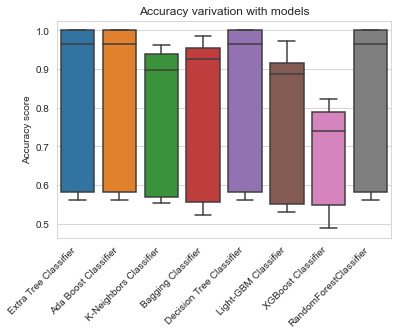

In [62]:
box = pd.DataFrame(accuracy,index=classifiers).T
sns.set_style('whitegrid')
ax = sns.boxplot(data=box)
ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
ax.set_ylabel("Accuracy score")
ax.set_title("Accuracy varivation with models")

Text(0.5, 1.0, 'Average CV Mean Accuracy')

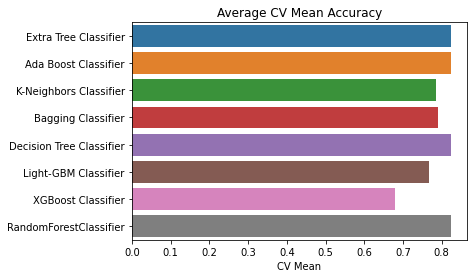

In [56]:
ax = sns.barplot(x=cv_df['CV Mean'],y=cv_df.index)
ax.set_title('Average CV Mean Accuracy')

In [66]:
cv_st_df = cv_df.style.background_gradient()
cv_st_df
dfi.export(cv_st_df, 'cv_results.png')

,CV Mean,Std
Extra Tree Classifier,0.823116,0.203685
Ada Boost Classifier,0.823116,0.203685
K-Neighbors Classifier,0.783980,0.181104
Bagging Classifier,0.789524,0.201471
Decision Tree Classifier,0.823116,0.203685
Light-GBM Classifier,0.767297,0.185728
XGBoost Classifier,0.680340,0.126276
RandomForestClassifier,0.823116,0.203685
